# Hadamard Multitask GP Regression

## Introduction

This notebook demonstrates how to perform "Hadamard" multitask regression. 
This differs from the [multitask gp regression example notebook](./Multitask_GP_Regression.ipynb) in one key way:

- Here, we assume that we have observations for **one task per input**. For each input, we specify the task of the input that we observe. (The kernel that we learn is expressed as a Hadamard product of an input kernel and a task kernel)
- In the other notebook, we assume that we observe all tasks per input. (The kernel in that notebook is the Kronecker product of an input kernel and a task kernel).

Multitask regression, first introduced in [this paper](https://papers.nips.cc/paper/3189-multi-task-gaussian-process-prediction.pdf) learns similarities in the outputs simultaneously. It's useful when you are performing regression on multiple functions that share the same inputs, especially if they have similarities (such as being sinusodial).

Given inputs $x$ and $x'$, and tasks $i$ and $j$, the covariance between two datapoints and two tasks is given by

$$  k([x, i], [x', j]) = k_\text{inputs}(x, x') * k_\text{tasks}(i, j)
$$

where $k_\text{inputs}$ is a standard kernel (e.g. RBF) that operates on the inputs.
$k_\text{task}$ is a special kernel - the `IndexKernel` - which is a lookup table containing inter-task covariance.

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

[KeOps] Warning : 
    The default C++ compiler could not be found on your system.
    You need to either define the CXX environment variable or a symlink to the g++ command.
    For example if g++-8 is the command you can do
      import os
      os.environ['CXX'] = 'g++-8'
    
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


### Set up training data

In the next cell, we set up the training data for this example. For each task we'll be using 50 random points on [0,1), which we evaluate the function on and add Gaussian noise to get the training labels. Note that different inputs are used for each task.

We'll have two functions - a sine function (y1) and a cosine function (y2).

In [2]:
train_x1 = torch.rand(50)
train_x2 = torch.rand(50)

train_y1 = torch.sin(train_x1 * (2 * math.pi)) + torch.randn(train_x1.size()) * 0.6
train_y2 = torch.cos(train_x2 * (2 * math.pi)) + torch.randn(train_x2.size()) * 0.2

## Set up a Hadamard multitask model

The model should be somewhat similar to the `ExactGP` model in the [simple regression example](../01_Exact_GPs/Simple_GP_Regression.ipynb).

The differences:

1. The model takes two input: the inputs (x) and indices. The indices indicate which task the observation is for.
2. Rather than just using a RBFKernel, we're using that in conjunction with a IndexKernel.
3. We don't use a ScaleKernel, since the IndexKernel will do some scaling for us. (This way we're not overparameterizing the kernel.)

In [3]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()
        
        # We learn an IndexKernel for 2 tasks
        # (so we'll actually learn 2x2=4 tasks with correlations)
        self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=2, rank=1)

    def forward(self,x,i):
        mean_x = self.mean_module(x)
        
        # Get input-input covariance
        covar_x = self.covar_module(x)
        # Get task-task covariance
        covar_i = self.task_covar_module(i)
        # Multiply the two together to get the covariance we want
        covar = covar_x.mul(covar_i)
        
        return gpytorch.distributions.MultivariateNormal(mean_x, covar)

likelihood = gpytorch.likelihoods.HadamardGaussianLikelihood(num_tasks=2)

train_i_task1 = torch.full((train_x1.shape[0],1), dtype=torch.long, fill_value=0)
train_i_task2 = torch.full((train_x2.shape[0],1), dtype=torch.long, fill_value=1)

full_train_x = torch.cat([train_x1, train_x2])
full_train_i = torch.cat([train_i_task1, train_i_task2])
full_train_y = torch.cat([train_y1, train_y2])

# Here we have two iterms that we're passing in as train_inputs
model = MultitaskGPModel((full_train_x, full_train_i), full_train_y, likelihood)

### Training the model

In the next cell, we handle using Type-II MLE to train the hyperparameters of the Gaussian process.

See the [simple regression example](../01_Exact_GPs/Simple_GP_Regression.ipynb) for more info on this step.

In [4]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(full_train_x, full_train_i)
    loss = -mll(output, full_train_y, [full_train_i])
    loss.backward()
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()

c:\Users\tobyb\phd\venvs\gpytorchvenv\lib\site-packages\linear_operator\utils\interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:620.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


Iter 1/50 - Loss: 1.118
Iter 2/50 - Loss: 1.084
Iter 3/50 - Loss: 1.047
Iter 4/50 - Loss: 1.010
Iter 5/50 - Loss: 0.975
Iter 6/50 - Loss: 0.941
Iter 7/50 - Loss: 0.908
Iter 8/50 - Loss: 0.876
Iter 9/50 - Loss: 0.847
Iter 10/50 - Loss: 0.823
Iter 11/50 - Loss: 0.803
Iter 12/50 - Loss: 0.787
Iter 13/50 - Loss: 0.774
Iter 14/50 - Loss: 0.761
Iter 15/50 - Loss: 0.748
Iter 16/50 - Loss: 0.734
Iter 17/50 - Loss: 0.720
Iter 18/50 - Loss: 0.704
Iter 19/50 - Loss: 0.689
Iter 20/50 - Loss: 0.673
Iter 21/50 - Loss: 0.658
Iter 22/50 - Loss: 0.643
Iter 23/50 - Loss: 0.629
Iter 24/50 - Loss: 0.616
Iter 25/50 - Loss: 0.604
Iter 26/50 - Loss: 0.593
Iter 27/50 - Loss: 0.584
Iter 28/50 - Loss: 0.576
Iter 29/50 - Loss: 0.571
Iter 30/50 - Loss: 0.567
Iter 31/50 - Loss: 0.566
Iter 32/50 - Loss: 0.567
Iter 33/50 - Loss: 0.568
Iter 34/50 - Loss: 0.570
Iter 35/50 - Loss: 0.572
Iter 36/50 - Loss: 0.572
Iter 37/50 - Loss: 0.573
Iter 38/50 - Loss: 0.573
Iter 39/50 - Loss: 0.573
Iter 40/50 - Loss: 0.574
Iter 41/5

### Make predictions with the model

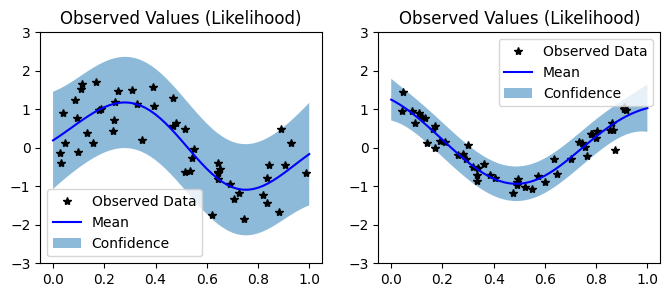

In [5]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Test points every 0.02 in [0,1]
test_x = torch.linspace(0, 1, 51)
test_i_task1 = torch.full((test_x.shape[0],1), dtype=torch.long, fill_value=0)
test_i_task2 = torch.full((test_x.shape[0],1), dtype=torch.long, fill_value=1)

# Make predictions - one task at a time
# We control the task we cae about using the indices

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred_y1 = likelihood(model(test_x, test_i_task1), [test_i_task1])
    observed_pred_y2 = likelihood(model(test_x, test_i_task2), [test_i_task2])

# Define plotting function
def ax_plot(ax, train_y, train_x, rand_var, title):
    # Get lower and upper confidence bounds
    lower, upper = rand_var.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.detach().numpy(), train_y.detach().numpy(), 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.detach().numpy(), rand_var.mean.detach().numpy(), 'b')
    # Shade in confidence 
    ax.fill_between(test_x.detach().numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

# Plot both tasks
ax_plot(y1_ax, train_y1, train_x1, observed_pred_y1, 'Observed Values (Likelihood)')
ax_plot(y2_ax, train_y2, train_x2, observed_pred_y2, 'Observed Values (Likelihood)')